In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import joblib
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [2]:
nCluster=8
df = pd.read_pickle("data/dataframe")
yearsString = ["14", "15", "16", "17", "18", "19", "20"]
arbevetel = ["TAH197"]
koltseg = ["TAC008",
"TAC009","TAC011","TAC010","TAC078","TAH014","TAH015","TAC012","TAC013","TAC014","TAC015","TAC016","TAC018","TAC063","TAH021","TAC109","TAC190","TAC059","TAB024","TAH197"]
merlegfoosszeg=["TAH186",
"TAH230","TAH033","TAH087","TAH088","TAH041","TAH042","TAH231","TAH043","TAH044","TAH232","TAH045", "TAH187", "TAI001",
"TAI002","TAI019","TAI020","TAI022","TAI023","TAI041","TAI042","TAI043","TAI044","TAI033","TAH034","TAI045","TAI046","TAI035","TAI047","TAI048","TAI036","TAI049","TAI050","TAI037","TAI051","TAI052","TAI053","TAI054","TAI055","TAI056","TAI057","TAH190","TAI038","TAI058", "TAB024","TAH197"]
liabilities = ["TAH209","TAH051","TAH227","TAH054","TAH055","TAH180","TAH199"]
toke = ["TAH002","TAH003","TAH004","TAH005","TAH011","TAH007","TAH233","TAH234","TAH012","TAH048","TAH189","TAH208","TAH060","TAH179","TAH187"]

ratios = pd.DataFrame()
for y in yearsString:
    for i in arbevetel:
        ratios[y+i+"arbev"] = df[y+i]/df[y+"TAC002"]
    for i in merlegfoosszeg:
        ratios[y+i+"mf"] = df[y+i]/df[y+"TAH061"]
    for i in liabilities:
        ratios[y+i+"liab"] = df[y+i]/(df[y+"TAH051"]+df[y+"TAH054"])
    for i in toke:
        ratios[y+i+"toke"] = df[y+i]/(df[y+"TAH001"]+df[y+"TAH012"]+df[y+"TAH048"]+df[y+"TAH189"]+df[y+"TAH208"]+df[y+"TAH060"]+df[y+"TAH179"]+df[y+"TAH187"]+df[y+"TAH059"])
    for i in koltseg:
        ratios[y+i+"kolt"] = df[y+i]/(df[y+"TAC002"]+df[y+"TAC006"]-df[y+"TAC019"])
ratios = ratios.replace(np.inf, 0)
ratios = ratios.replace(-np.inf, 0)        
ratios.fillna(0, inplace=True)
        
cRatios = pd.DataFrame()
for y in range(14, 20):
    for i in arbevetel:
        cRatios[str(y)+"c"+str(y+1)+i+"arbev"] = (ratios[str(y+1)+i+"arbev"]-ratios[str(y)+i+"arbev"])/ratios[str(y)+i+"arbev"]
    for i in merlegfoosszeg:
        cRatios[str(y)+"c"+str(y+1)+i+"mf"] = (ratios[str(y+1)+i+"mf"]-ratios[str(y)+i+"mf"])/ratios[str(y)+i+"mf"]
    for i in liabilities:
        cRatios[str(y)+"c"+str(y+1)+i+"liab"] = (ratios[str(y+1)+i+"liab"]-ratios[str(y)+i+"liab"])/ratios[str(y)+i+"liab"]
    for i in toke:
        cRatios[str(y)+"c"+str(y+1)+i+"toke"] = (ratios[str(y+1)+i+"toke"]-ratios[str(y)+i+"toke"])/ratios[str(y)+i+"toke"]
    for i in koltseg:
        cRatios[str(y)+"c"+str(y+1)+i+"kolt"] = (ratios[str(y+1)+i+"kolt"]-ratios[str(y)+i+"kolt"])/ratios[str(y)+i+"kolt"]

cRatios = cRatios.replace(np.inf, 0)
cRatios = cRatios.replace(-np.inf, 0)        
cRatios.fillna(0, inplace=True)

prodInTime = pd.DataFrame()
for i in range(14, 21): 
    prodInTime[str(i)] = df[str(i)+"Productivity"]
prodInTime = TimeSeriesScalerMeanVariance().fit_transform(prodInTime)

timeSeriesClusterModel = TimeSeriesKMeans(n_clusters=nCluster, metric="dtw", max_iter=10, random_state=15)
timeSeriesClusterModel.fit(prodInTime)
targetLabels = timeSeriesClusterModel.predict(prodInTime)

<ipython-input-2-6e81f529eb55>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios[y+i+"mf"] = df[y+i]/df[y+"TAH061"]
<ipython-input-2-6e81f529eb55>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios[y+i+"liab"] = df[y+i]/(df[y+"TAH051"]+df[y+"TAH054"])
<ipython-input-2-6e81f529eb55>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fr

In [4]:
ctrainX = []
ctrainY = []
cstackX = []
cstackY = []
ctestX = []
ctestY = []
for c in range(0, nCluster):
    cRatiosMask = np.load("cRatiosRFEMaskC"+str(c)+".npy")
    cRatiosCluster = cRatios[cRatios.columns[cRatiosMask]]
    train_X, rem_X, train_Y, rem_Y = train_test_split(cRatiosCluster, targetLabels == c, test_size=0.5, random_state=42)
    stack_X, test_X, stack_Y, test_Y = train_test_split(rem_X, rem_Y, test_size=0.3, random_state=42)
    ctrainX.append(train_X)
    ctrainY.append(train_Y)
    cstackX.append(stack_X)
    cstackY.append(stack_Y)
    ctestX.append(test_X)
    ctestY.append(test_Y)

In [5]:
ntrainX = []
ntrainY = []
nstackX = []
nstackY = []
ntestX = []
ntestY = []
for c in range(0, nCluster):
    ratiosMask = np.load("ratiosRFEMaskC"+str(c)+".npy")
    ratiosCluster = ratios[ratios.columns[ratiosMask]]
    train_X, rem_X, train_Y, rem_Y = train_test_split(ratiosCluster, targetLabels == c, test_size=0.5, random_state=42)
    stack_X, test_X, stack_Y, test_Y = train_test_split(rem_X, rem_Y, test_size=0.3, random_state=42)
    ntrainX.append(train_X)
    ntrainY.append(train_Y)
    nstackX.append(stack_X)
    nstackY.append(stack_Y)
    ntestX.append(test_X)
    ntestY.append(test_Y)

In [20]:
ratiosMask = np.load("ratiosRFEMask.npy")
ratiosCluster = ratios[ratios.columns[ratiosMask]]
tL = np.logical_or(np.logical_or(targetLabels == 4, targetLabels == 7), np.logical_or(targetLabels == 3, targetLabels == 1))
train_X, rem_X, train_Y, rem_Y = train_test_split(ratiosCluster, tL, test_size=0.5, random_state=42)
stack_X, test_X, stack_Y, test_Y = train_test_split(rem_X, rem_Y, test_size=0.3, random_state=42)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(train_X, train_Y)
gbc = GradientBoostingClassifier(max_depth = 12, n_estimators = 45)
gbc.fit(x_res, y_res)
rfc = RandomForestClassifier(max_depth = 14, n_estimators = 40)
rfc.fit(x_res, y_res)
lrm = LogisticRegression(solver='saga', C=4.5, max_iter=5000)
lrm.fit(x_res, y_res)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(stack_X, stack_Y)
estimators = [
        ('gbc', gbc),
        ('rf', rfc),
        ('lr', lrm) ]
stackingModel = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), cv='prefit', passthrough = True)
stackingModel.fit(x_res, y_res)
print(metrics.confusion_matrix(test_Y, stackingModel.predict(test_X)))
print(metrics.f1_score(test_Y, stackingModel.predict(test_X)))

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[ 482  223]
 [ 374 1002]]
0.7704728950403691


In [18]:
ratiosMask = np.load("ratiosRFEMask.npy")
ratiosCluster = ratios[ratios.columns[ratiosMask]]
tL = np.logical_or(np.logical_or(targetLabels == 4, targetLabels == 7), np.logical_or(targetLabels == 3, targetLabels == 1))
train_X, rem_X, train_Y, rem_Y = train_test_split(ratiosCluster, tL, test_size=0.5, random_state=42)
stack_X, test_X, stack_Y, test_Y = train_test_split(rem_X, rem_Y, test_size=0.3, random_state=42)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(train_X, train_Y)
gbc = GradientBoostingClassifier(max_depth = 12, n_estimators = 45)
gbc.fit(x_res, y_res)
rfc = RandomForestClassifier(max_depth = 14, n_estimators = 40)
rfc.fit(x_res, y_res)
lrm = LogisticRegression(solver='saga', C=4, max_iter=5000)
lrm.fit(x_res, y_res)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(stack_X, stack_Y)
estimators = [
        ('gbc', gbc),
        ('rf', rfc),
        ('lr', lrm) ]
stackingModel = VotingClassifier(estimators=estimators, voting='soft')
stackingModel.fit(x_res, y_res)
print(metrics.confusion_matrix(test_Y, stackingModel.predict(test_X)))
print(metrics.f1_score(test_Y, stackingModel.predict(test_X)))

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[ 409  296]
 [ 278 1098]]
0.7927797833935019


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


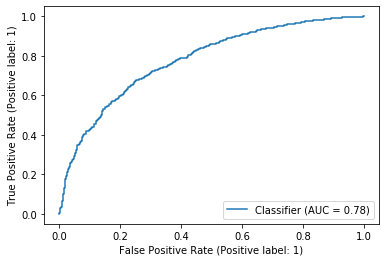

In [21]:
metrics.RocCurveDisplay.from_predictions(test_Y, stackingModel.predict_proba(test_X)[:, 1])

# Gradient Boosting with SMOTE, change values, RFE

In [7]:
gradientResultSmote=joblib.load("gradientResultSMOTE.pkl")
gradientModels = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ctrainX[c], ctrainY[c])
    parameters = gradientResultSmote[c].best_params_
    gbc = GradientBoostingClassifier(**parameters)
    gbc.fit(x_res, y_res)
    gradientModels.append(gbc)

# Random Forest with SMOTE, change values, RFE

In [9]:
randomForestResultSmote=joblib.load("randomForestResultSMOTE.pkl")
rfModels = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ctrainX[c], ctrainY[c])
    parameters = randomForestResultSmote[c].best_params_
    rfc = RandomForestClassifier(**parameters)
    rfc.fit(x_res, y_res)
    rfModels.append(rfc)

# Logistic regression with SMOTE, change values, RFE

In [14]:
lrResultSmote=joblib.load("lrResultSMOTE.pkl")
lrModels = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ctrainX[c], ctrainY[c])
    parameters = lrResultSmote[c].best_params_
    lrm = LogisticRegression(solver='saga', **parameters, max_iter=5000)
    lrm.fit(x_res, y_res)
    lrModels.append(lrm)

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

In [46]:
stackingClass = []
stackingVote = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(cstackX[c], cstackY[c])
    estimators = [
        ('gbc', gradientModels[c]),
        ('rf', rfModels[c]),
        ('lr', lrModels[c]) ]
    stackingModel = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=5000), cv='prefit', passthrough = True)
    stackingClass.append(stackingModel.fit(x_res, y_res))

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

In [47]:
for c in range(0, nCluster):
    print(c)
    print(metrics.confusion_matrix(ctestY[c], stackingClass[c].predict(ctestX[c])))
    print(metrics.f1_score(ctestY[c], stackingClass[c].predict(ctestX[c])))
    print("--------------")

0
[[1476  437]
 [  83   85]]
0.24637681159420288
--------------
1
[[1376  487]
 [ 153   65]]
0.16883116883116883
--------------
2
[[1411  487]
 [ 101   82]]
0.2180851063829787
--------------
3
[[1352  456]
 [ 190   83]]
0.2044334975369458
--------------
4
[[1240  466]
 [ 196  179]]
0.3509803921568628
--------------
5
[[1461  456]
 [  85   79]]
0.22603719599427752
--------------
6
[[1515  376]
 [ 118   72]]
0.225705329153605
--------------
7
[[1149  422]
 [ 237  273]]
0.4531120331950207
--------------


In [60]:
stackingVote = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ctrainX[c], ctrainY[c])
    voteModel = VotingClassifier(estimators = [
        ('gbc', gradientModels[c]),
        ('rf', rfModels[c]),
        ('lr', lrModels[c]),
        ('nb', GaussianNB())], voting='hard')
    stackingVote.append(voteModel.fit(x_res, y_res))

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

In [61]:
for c in range(0, nCluster):
    print(c)
    print(metrics.confusion_matrix(ctestY[c], stackingVote[c].predict(ctestX[c])))
    print(metrics.f1_score(ctestY[c], stackingVote[c].predict(ctestX[c])))
    print("--------------")

0
[[1576  337]
 [  95   73]]
0.2525951557093426
--------------
1
[[1539  324]
 [ 187   31]]
0.10820244328097732
--------------
2
[[1497  401]
 [ 110   73]]
0.2222222222222222
--------------
3
[[1532  276]
 [ 222   51]]
0.17
--------------
4
[[1261  445]
 [ 185  190]]
0.3762376237623763
--------------
5
[[1553  364]
 [ 101   63]]
0.21319796954314718
--------------
6
[[1623  268]
 [ 137   53]]
0.20743639921722112
--------------
7
[[1197  374]
 [ 264  246]]
0.4353982300884956
--------------


In [13]:
joblib.dump(stackedModelsC, "stackedModelsC.pkl")

['lrResultSMOTE.pkl']

# GradientBoosting with SMOTE nominal values RFE

In [50]:
gradientResultSmoteN=joblib.load("gradientResultSMOTEN.pkl")
gradientModelsN = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ntrainX[c], ntrainY[c])
    parameters = gradientResultSmoteN[c].best_params_
    gbc = GradientBoostingClassifier(**parameters)
    gbc.fit(x_res, y_res)
    gradientModelsN.append(gbc)

# RandomForest with SMOTE nominal values RFE

In [56]:
randomForestResultSmoteN=joblib.load("randomForestResultCSMOTEN.pkl")
rfModelsN = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ntrainX[c], ntrainY[c])
    parameters = randomForestResultSmoteN[c].best_params_
    rfc = RandomForestClassifier(**parameters)
    rfc.fit(x_res, y_res)
    rfModelsN.append(rfc)

In [57]:
lrResultSmoteN=joblib.load("lrResultCSMOTEN.pkl")
lrModelsN = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ntrainX[c], ntrainY[c])
    parameters = lrResultSmoteN[c].best_params_
    lrm = LogisticRegression(solver='saga', **parameters, max_iter=5000)
    lrm.fit(x_res, y_res)
    lrModelsN.append(lrm)

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

In [58]:
stackingClassN = []
stackingVote = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(nstackX[c], nstackY[c])
    estimators = [
        ('gbc', gradientModelsN[c]),
        ('rf', rfModelsN[c]),
        ('lr', lrModelsN[c]) ]
    stackingModel = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=5000), cv='prefit', passthrough = True)
    stackingClassN.append(stackingModel.fit(x_res, y_res))

In [59]:
for c in range(0, nCluster):
    print(c)
    print(metrics.confusion_matrix(ntestY[c], stackingClassN[c].predict(ntestX[c])))
    print(metrics.f1_score(ntestY[c], stackingClassN[c].predict(ntestX[c])))
    print("--------------")

0
[[1488  425]
 [  88   80]]
0.23774145616641898
--------------
1
[[1392  471]
 [ 146   72]]
0.18922470433639949
--------------
2
[[1515  383]
 [  76  107]]
0.3179791976225855
--------------
3
[[1336  472]
 [ 160  113]]
0.2634032634032634
--------------
4
[[1263  443]
 [ 177  198]]
0.3897637795275591
--------------
5
[[1459  458]
 [  84   80]]
0.22792022792022792
--------------
6
[[1453  438]
 [ 105   85]]
0.23842917251051896
--------------
7
[[1144  427]
 [ 218  292]]
0.47518307567127743
--------------


In [64]:
stackingVoteN = []
for c in range(0, nCluster):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(ntrainX[c], ntrainY[c])
    voteModel = VotingClassifier(estimators = [
        ('gbc', gradientModelsN[c]),
        ('rf', rfModelsN[c]),
        ('lr', lrModelsN[c]),
        ], voting='hard')
    stackingVoteN.append(voteModel.fit(x_res, y_res))

C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

In [65]:
for c in range(0, nCluster):
    print(c)
    print(metrics.confusion_matrix(ntestY[c], stackingVoteN[c].predict(ntestX[c])))
    print(metrics.f1_score(ntestY[c], stackingVoteN[c].predict(ntestX[c])))
    print("--------------")

0
[[1424  489]
 [  85   83]]
0.2243243243243243
--------------
1
[[1469  394]
 [ 163   55]]
0.16491754122938532
--------------
2
[[1491  407]
 [  89   94]]
0.27485380116959063
--------------
3
[[1285  523]
 [ 168  105]]
0.23307436182019978
--------------
4
[[1229  477]
 [ 168  207]]
0.3909348441926346
--------------
5
[[1476  441]
 [  96   68]]
0.20208023774145617
--------------
6
[[1496  395]
 [ 116   74]]
0.22458270106221548
--------------
7
[[1120  451]
 [ 241  269]]
0.4373983739837398
--------------


In [ ]:
finalModel = StackingClassifier(estimators=stackingClass, final_estimator=LogisticRegression(max_iter=5000), cv='prefit', passthrough = False)
finalModel = finalModel.fit(cCluster, targetLabels))